In [1]:
# Library needed
from numpy import expand_dims, dot, asarray, array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
from tqdm import tqdm
import random
import numpy as np
import os
import time
import cv2
import pickle
import h5py

In [2]:
# Configuration
IMG_H = 300 
IMG_W = 300
EPOCHS = 10
BATCH_SIZE = 32
SPLIT = 0.2
SAMPLE = 400
AUG_NUM = 3 # aug 5
SHIFT_RANGE = 0.1
ROTATION_RANGE = 10
DROPOUT_RATE=0.3
MODEL_NAME = "scratch_one.h5"

CATEGORIES = ["rendah", "tinggi"]

In [3]:
def create_augmentation(filename, label):
    # load the image
    img = load_img(filename)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(rotation_range=ROTATION_RANGE,
        width_shift_range=SHIFT_RANGE,
        height_shift_range=SHIFT_RANGE,
        horizontal_flip=True)
    # prepare iterator
    it = datagen.flow(samples)
    # augmentation list of this image 
    aug_list = []
    # generate samples and plot
    for i in range(AUG_NUM):
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0]
        gray = dot(image[...,:3], [0.299, 0.587, 0.144])
        gray_nd_array = asarray(gray)
        resized_gray_nd_array = cv2.resize(gray_nd_array, (IMG_H, IMG_W))
        aug_list.append([resized_gray_nd_array, CATEGORIES.index(label)])
    return aug_list
    

# Loading & creating augmentation of the data

In [4]:
training_data = []
cwd = os.getcwd()
data_path = os.path.join(cwd, "datalama")
# untuk tiap folder (rendah & tinggi)
for category in CATEGORIES:
    # path folder ini
    dirpath = os.path.join(data_path, category)
    # dapatkan list nama file 
    filenames = os.listdir(dirpath)
    # sampling sebanyak jumlah SAMPLE yang ditentukan di konfigurasi
    # filenames = random.choices(filenames, k=SAMPLE)

    with tqdm(total=len(filenames)) as pbar:
        pbar.set_description("Doing augmentation for category  {}".format(category))
        for filename in filenames:
            try:
                filepath = os.path.join(dirpath, filename)
                aug_list = create_augmentation(filepath, category)
                training_data += aug_list
            except Exception as e:
                print(str(e))
            pbar.update(1)


Doing augmentation for category  tinggi:  28%|██▊       | 119/418 [00:19<00:43,  6.89it/s]

[Errno 21] Is a directory: '/home/syafiq/skripsi/datalama/tinggi/.ipynb_checkpoints'


Doing augmentation for category  tinggi: 100%|██████████| 418/418 [01:09<00:00,  5.98it/s]


In [5]:
# Shuffling the training data to avoid bias due to sequencial learning 
random.shuffle(training_data)
random.shuffle(training_data)

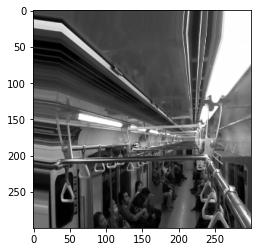

rendah


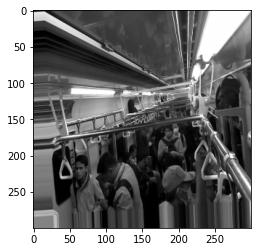

tinggi


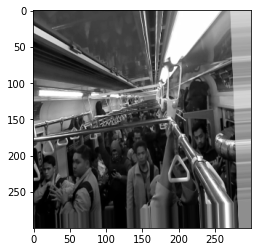

tinggi


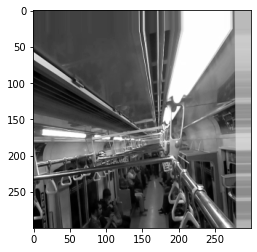

rendah


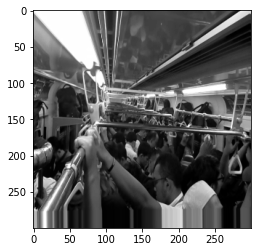

tinggi


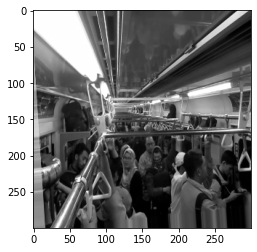

tinggi


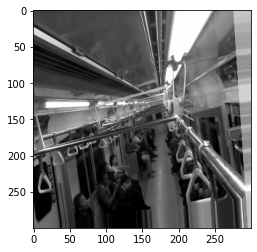

rendah


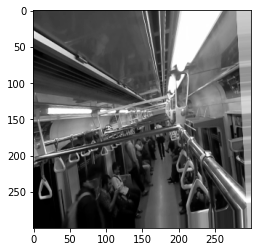

rendah


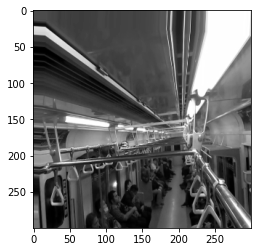

rendah


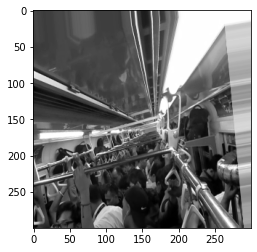

tinggi


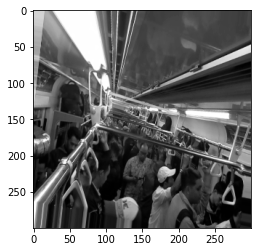

tinggi


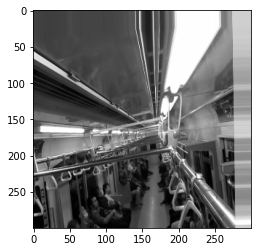

rendah


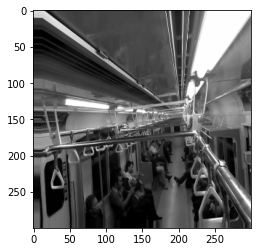

rendah


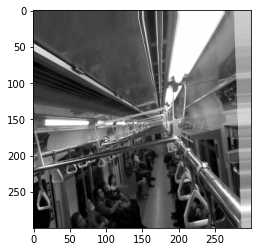

rendah


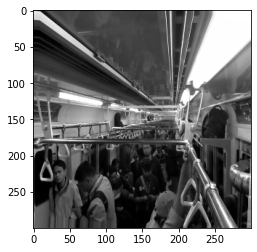

tinggi


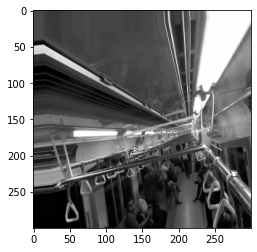

rendah


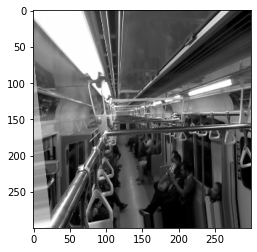

rendah


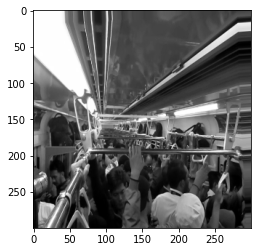

tinggi


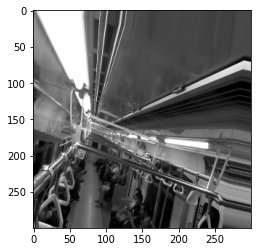

rendah


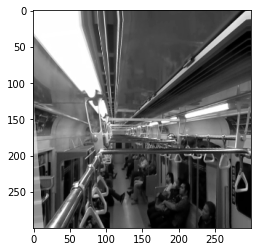

rendah


In [6]:
# try showing the image of the preprocessed data
for i in range(0, 20):
    ndarr = training_data[i][0]
    pyplot.imshow(ndarr, cmap="gray")
    pyplot.show()
    print(CATEGORIES[training_data[i][1]])

In [7]:
len(training_data)

3036

In [8]:
training_data[2][0].shape

(300, 300)

In [9]:
x = [] # Features 
y = [] # Labels

for data in training_data:
    x.append(data[0])
    y.append(data[1])

x = array(x).reshape(-1, IMG_H, IMG_W, 1)

# normalize
x = x/255.0

In [10]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = x.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_RATE))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_RATE))

model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

x = array(x)
y = array(y)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=SPLIT, callbacks=[es])
model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=SPLIT)

Train on 2428 samples, validate on 608 samples
Epoch 1/10
2428/2428 [==============================] - 112s 46ms/sample - loss: 2.3219 - accuracy: 0.6063 - val_loss: 0.5864 - val_accuracy: 0.6809
Epoch 2/10
2428/2428 [==============================] - 112s 46ms/sample - loss: 0.4246 - accuracy: 0.8151 - val_loss: 0.3172 - val_accuracy: 0.8931
Epoch 3/10
2428/2428 [==============================] - 112s 46ms/sample - loss: 0.2674 - accuracy: 0.8925 - val_loss: 0.2428 - val_accuracy: 0.9276
Epoch 4/10
2428/2428 [==============================] - 113s 46ms/sample - loss: 0.1729 - accuracy: 0.9382 - val_loss: 0.2026 - val_accuracy: 0.9457
Epoch 5/10
2428/2428 [==============================] - 113s 46ms/sample - loss: 0.1454 - accuracy: 0.9489 - val_loss: 0.1904 - val_accuracy: 0.9359
Epoch 6/10
2428/2428 [==============================] - 113s 46ms/sample - loss: 0.1018 - accuracy: 0.9650 - val_loss: 0.2261 - val_accuracy: 0.9309
Epoch 7/10
2428/2428 [==============================] - 113

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x, y)
print('Test accuracy:', test_acc)
save_model(model, MODEL_NAME, save_format="h5")

3036/3036 [==============================] - 24s 8ms/sample - loss: 0.0436 - accuracy: 0.9918
Test accuracy: 0.9917655


In [12]:
# load the model
path = MODEL_NAME 
model_obj = h5py.File(path, "r+")
model = load_model(model_obj, compile=False)

# Testing
# Function to prepare the image to be predicted 
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_H, IMG_W))
    return new_array.reshape(-1, IMG_H, IMG_W, 1)

# Function to predict the image 
def predict(filepath):
    prediction = model.predict([prepare(filepath)])
    print(CATEGORIES[int(prediction[0][0])])
    return CATEGORIES[int(prediction[0][0])]

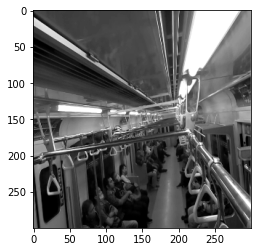

rendah


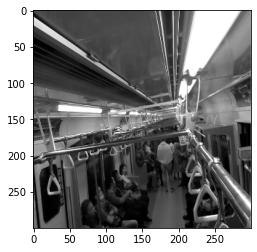

rendah


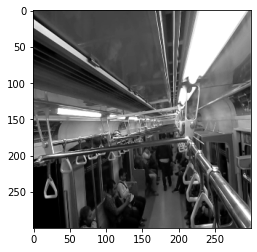

rendah


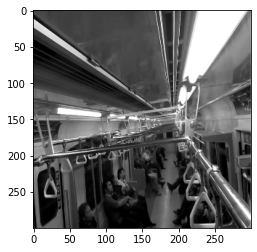

rendah


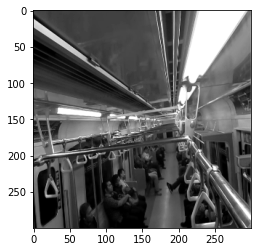

rendah


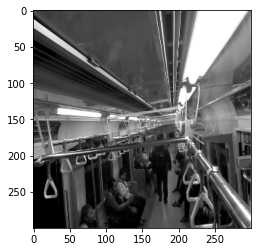

rendah


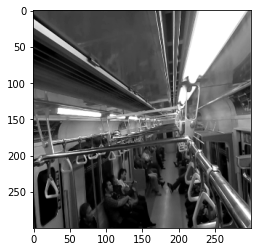

rendah


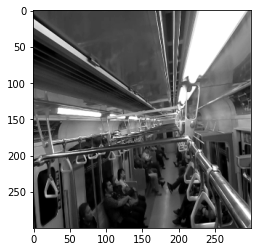

rendah


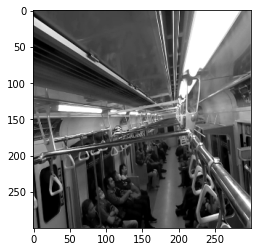

rendah


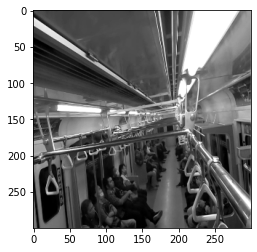

rendah


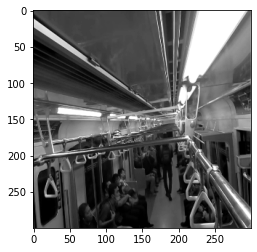

rendah


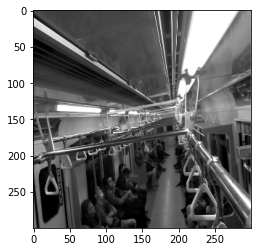

rendah


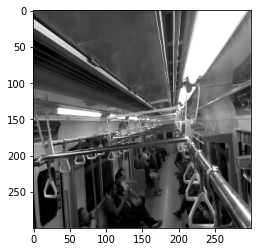

rendah


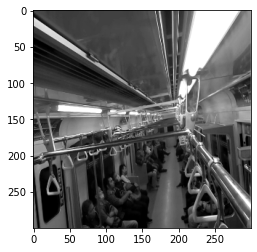

rendah


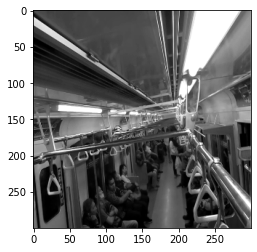

rendah


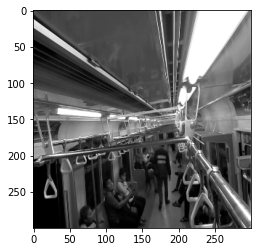

rendah


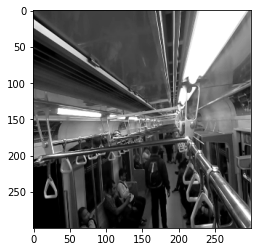

rendah


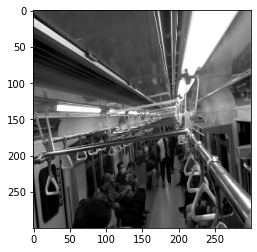

rendah


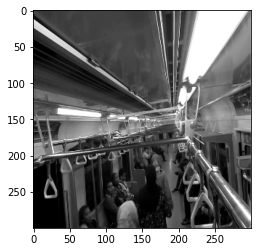

rendah


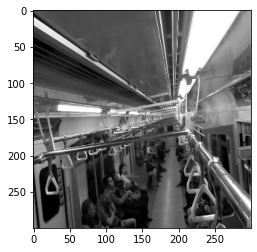

rendah


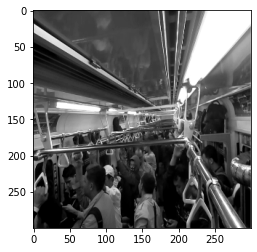

rendah


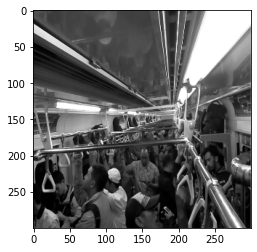

rendah


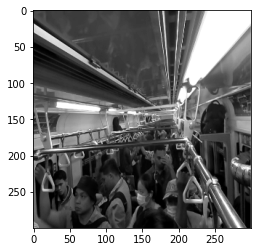

rendah


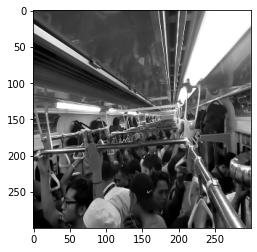

rendah


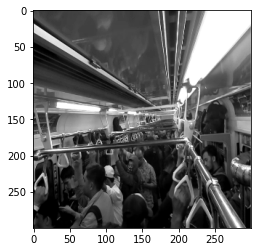

rendah


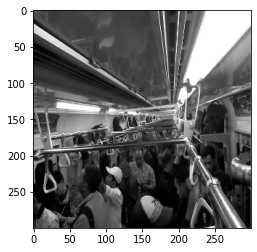

rendah


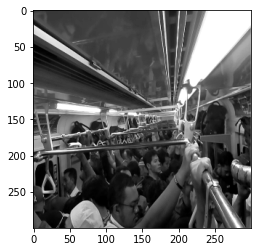

rendah


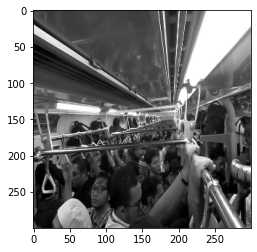

rendah


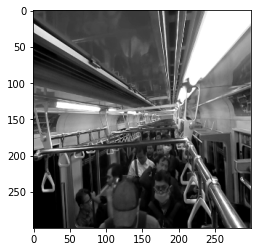

tinggi


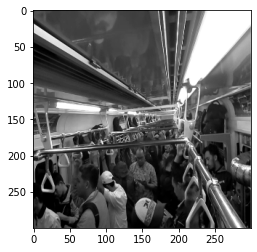

rendah


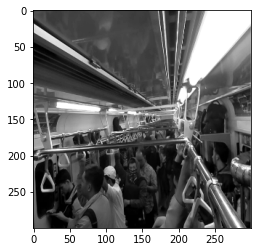

rendah


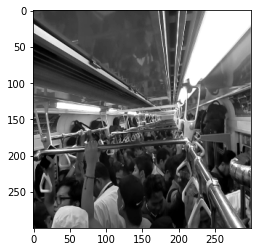

rendah


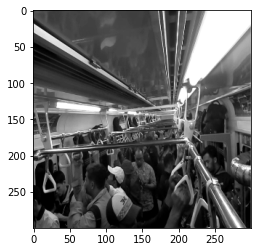

rendah


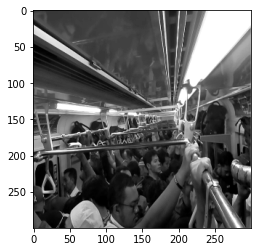

rendah


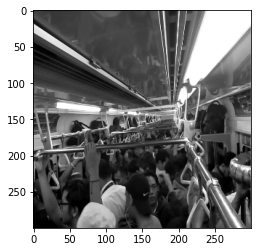

rendah


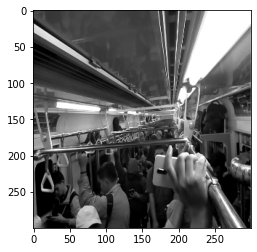

rendah


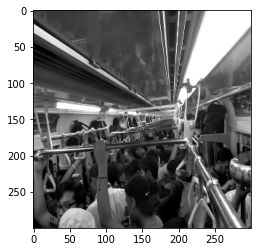

rendah


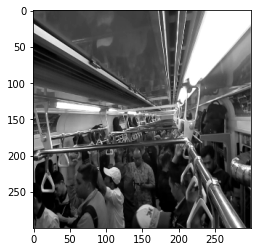

rendah


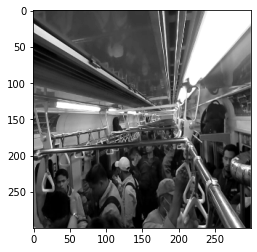

rendah


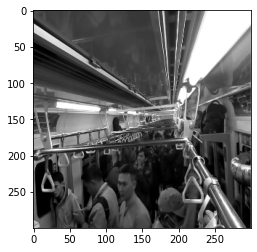

rendah
Akurasi=52.5%


In [13]:
# Testing dengan 20 gambar sample per kategori yang diambil dari training data yang belum teraugmentasi
right_prediction_counter = 0
img_counter = 0
test_list = []

for category in CATEGORIES:
    # path folder ini
    dirpath = os.path.join(data_path, category)
    # dapatkan list nama file 
    filenames = os.listdir(dirpath)
    # sampling sebanyak jumlah SAMPLE yang ditentukan di konfigurasi
    filenames = random.choices(filenames, k=20)
    
    for filename in filenames:
        path = os.path.join(dirpath, filename)
        img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_H, IMG_W))
        pyplot.imshow(new_array, cmap="gray")
        pyplot.show()
        img_counter += 1
        result = predict(path)
        if result == category:
            right_prediction_counter += 1

print(f"Akurasi={right_prediction_counter*100/img_counter}%")

/home/syafiq/skripsi/test-google-baru/rendah/bnREOmeL4f.jpg


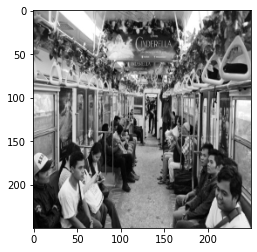

rendah

/home/syafiq/skripsi/test-google-baru/rendah/15409064941489469359.jpg


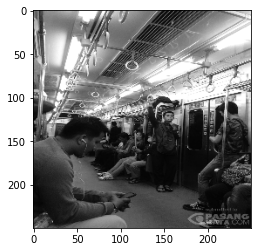

rendah

/home/syafiq/skripsi/test-google-baru/rendah/181344320160729-161527780x390.jpg


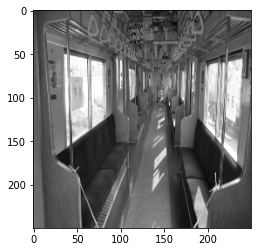

rendah

/home/syafiq/skripsi/test-google-baru/rendah/317-com-800x450.jpg


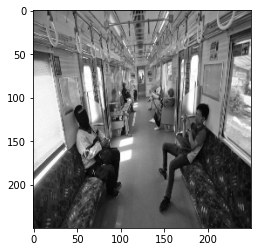

rendah

/home/syafiq/skripsi/test-google-baru/rendah/700095_720.jpg


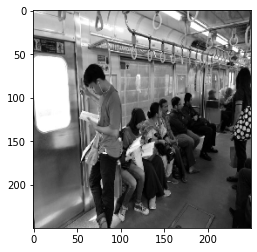

rendah

/home/syafiq/skripsi/test-google-baru/rendah/021995900_1564915437-20190804-Stasiun-Jatinegara-4.jpg


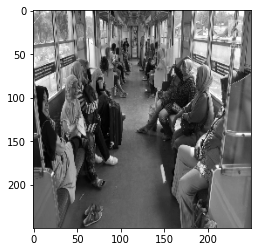

rendah

/home/syafiq/skripsi/test-google-baru/rendah/wanita^.jpg


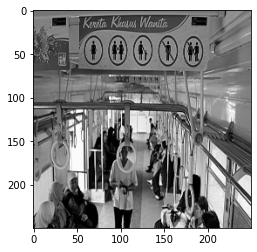

rendah

/home/syafiq/skripsi/test-google-baru/rendah/962019160.jpg


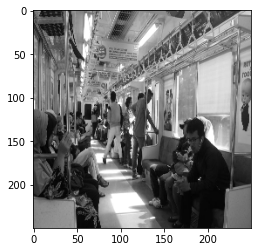

rendah

/home/syafiq/skripsi/test-google-baru/rendah/3070052400_fPRnAvMg_commuter-line.jpg


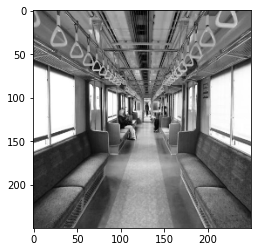

rendah

/home/syafiq/skripsi/test-google-baru/rendah/penumpang_krl4-750x630.jpg


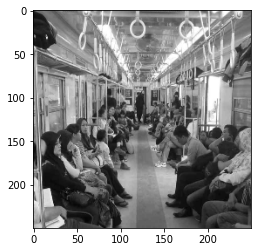

rendah

/home/syafiq/skripsi/test-google-baru/rendah/44829_620.jpg


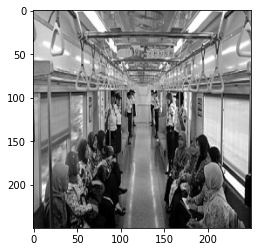

rendah

/home/syafiq/skripsi/test-google-baru/rendah/cogw9olcod4esxxqdnkh.jpg


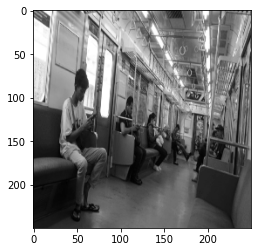

rendah

/home/syafiq/skripsi/test-google-baru/rendah/20140409_205024_gerbong-krl-lengang.jpg


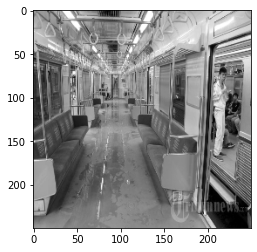

rendah

/home/syafiq/skripsi/test-google-baru/tinggi/24714-ilustrasi-penumpang-krl-commuter-line.jpg


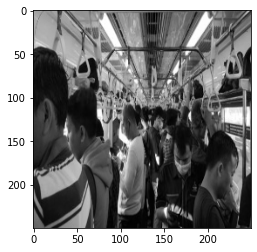

rendah

/home/syafiq/skripsi/test-google-baru/tinggi/095117020130402NUT03p.jpg


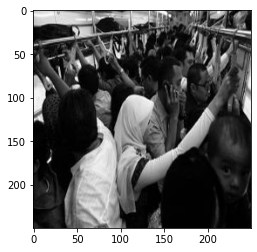

rendah

/home/syafiq/skripsi/test-google-baru/tinggi/175640820140730-164553p.jpg


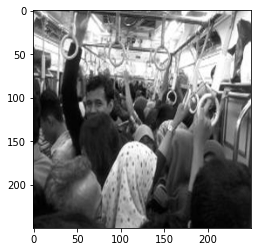

rendah

/home/syafiq/skripsi/test-google-baru/tinggi/desak-desakan-di-krl-seorang-wanita-hampir-pingsan-B5BXeCtERW.jpg


In [ ]:
# Testing menggunakan gambar dari Google 
dir_test_google_baru = "test-google-baru"
right_prediction_counter = 0
img_counter = 0

for category in CATEGORIES:
    for img in os.listdir(os.path.join(cwd, dir_test_google_baru, category)):
        path = os.path.join(cwd, dir_test_google_baru, category, img)
        print(path)
        try:
            img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (250, 250))
            pyplot.imshow(new_array, cmap="gray")
            pyplot.show()
            img_counter += 1
            result = predict(path)
            if result == category:
                right_prediction_counter += 1
        except Exception as e:
            print(e)
            pass
        print()

print(f"Akurasi={right_prediction_counter*100/img_counter}%")